# Imports

FastAI makes prototyping deep learning models simple.     
Hoever the library is not updated to pip frequnetly. 

In [1]:
import sys
sys.path.append("/home/ubuntu/fastai/")

In [2]:
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from glob import glob
import pandas as pd
import helper
from tqdm import tqdm
import hashlib
from urllib import request


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# sorted by size of data
#DATASET_NAME = "dog_breed"
#DATASET_NAME = "leaf"
#DATASET_NAME = "food"
DATASET_NAME = "bird"
#DATASET_NAME = "fungus"

PATH = f"data/{DATASET_NAME}"

In [5]:
!ls {PATH}

labels.csv  train  valid


# Train data

transformations to apply on the image

In [6]:
transforms_side_on

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
                           max_zoom=1.1)
    data = ImageClassifierData.from_paths(path=PATH
            , num_workers=8
            , tfms=tfms, bs=bs)
    #return data.resize(sz, 'tmp')
    return data if sz>300 else data.resize(340, 'tmp')

In [8]:
sz = 224 # size of image
arch = resnet34 #model architecture..
bs=128 # batch size; number of images to process at one time

In [9]:
! rm -rf {PATH}/tmp/

** Train with precompute weights **       
To speed up training, you can disable data augmentation.      
When data augmentation is off, you can cache the precomputed weights

In [10]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lrs=1e-2, n_cycle=3)

                                                   
100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


epoch      trn_loss   val_loss   accuracy                
    0      1.481328   0.565226   0.837743  
    1      0.900188   0.27176    0.938272                 
    2      0.643746   0.202109   0.957672                  



[array([0.20211]), 0.9576719576719577]

** Train with data augmentation **

In [11]:
learn.precompute = False
learn.fit(lrs=1e-2, n_cycle=5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.395512   0.194808   0.954145  
    1      0.362819   0.178513   0.957672                  
    2      0.345759   0.166467   0.968254                  
    3      0.329987   0.151121   0.971781                  
    4      0.323441   0.143973   0.970018                  



[array([0.14397]), 0.9700176366843033]

** Train more with layer unfreezing **

In [12]:
#learn.unfreeze()

In [13]:
#lr=1e-2
#lr=np.array([lr/18,lr/6,lr/2])

In [14]:
#learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [15]:
!ls

converted_model.tflite	     graph.lite		   model_benchmark
data			     helper.py		   models
dobgreed_mobilenet_tf.ipynb  keras.ipynb	   prep.ipynb
dobgreed_resnet.ipynb	     keras_parallel.ipynb  __pycache__
dog_breed.h5		     keras_parallel.py	   sector_labelling.ipynb
dog_breed.mlmodel	     labels.csv		   tensorflow_export.ipynb
dog_breed_tf.h5		     labels.txt		   tensorflow_tf_keras.ipynb
downloads		     MobileNet.ipynb	   tmp
fastai.ipynb		     model


** calculate accuracy with test time augmentation **

In [16]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0) # normalize accuracies to between 0 - 1
(metrics.log_loss(y,preds), accuracy_np(preds,y))

(0.15604634314768415, 0.9700176366843033)

In [17]:
predicted_class = np.argmax(preds, axis=1)
confidence = np.max(preds, axis=1)

In [18]:
predictions_df = pd.DataFrame ({'actual': y, 'pred': predicted_class,'image':learn.data.val_ds.fnames,'conf':confidence})

In [19]:
predictions_df['actual_class'] = predictions_df['actual'].apply(lambda x : data.classes[x])
predictions_df['pred_class'] = predictions_df['pred'].apply(lambda x : data.classes[x])

In [20]:
predictions_df.head()


,actual,pred,image,conf,actual_class,pred_class
0,0,0,valid/american_goldfinch/c8f48de17c7c4819bdce8...,0.999421,american_goldfinch,american_goldfinch
1,0,0,valid/american_goldfinch/d0379c186b264b779c1e3...,0.677824,american_goldfinch,american_goldfinch
2,0,0,valid/american_goldfinch/5964700c5d114aaba4378...,0.967887,american_goldfinch,american_goldfinch
3,0,0,valid/american_goldfinch/7db5f010753e4262ae032...,0.997771,american_goldfinch,american_goldfinch
4,0,0,valid/american_goldfinch/f82c83f4e9f1440899a00...,0.922290,american_goldfinch,american_goldfinch


In [21]:
def predict_class(image_path:str):
    """
    Given an image path (local filesystem), return most top predictions
    """
    
    # retrieve the transformation functions used by the DNN architecture
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    # read image and apply transforms
    im = val_tfms(np.array(open_image(image_path)))

    # get probability for all n classes
    preds = learn.predict_array(im[None])
    # get idx of most likely class
    class_idx = np.argmax(preds)
    
    print(data.classes[class_idx],np.max(preds))
    
    return helper.get_top_n_predictions(np.exp(preds), data.classes)
    #return np.argmax(preds)

def predict_class_web(url,ext="jpg"):
    url_hash = hashlib.md5(url.encode('utf-8')).hexdigest()
    file_name = f'data/downloaded/{url_hash}.{ext}'
    f = open(file_name, 'wb')
    f.write(request.urlopen(url).read())
    f.close()
    
    return predict_class(file_name)

In [22]:
!mkdir -p data/downloaded

In [23]:
predict_class_web("https://vetstreet.brightspotcdn.com/dims4/default/3407f3b/2147483647/thumbnail/645x380/quality/90/?url=https%3A%2F%2Fvetstreet-brightspot.s3.amazonaws.com%2Ffb%2F31%2F032a6aae436a9821acda211044fb%2Fbulldog-ap-rn4myi-645.jpg")

mallard -0.07011652


[('mallard', 0.9322852),
 ('dark-eyed_junco', 0.021107208),
 ('red-tailed_hawk', 0.038156472),
 ('european_starling', 0.0028028283),
 ('red-winged_blackbird', 0.0020750735)]

In [24]:
len(preds.shape)

2

** Confusion Matrix**

In [25]:
labels = learn.data.classes
cm = confusion_matrix(predictions_df['actual'], predictions_df['pred'])

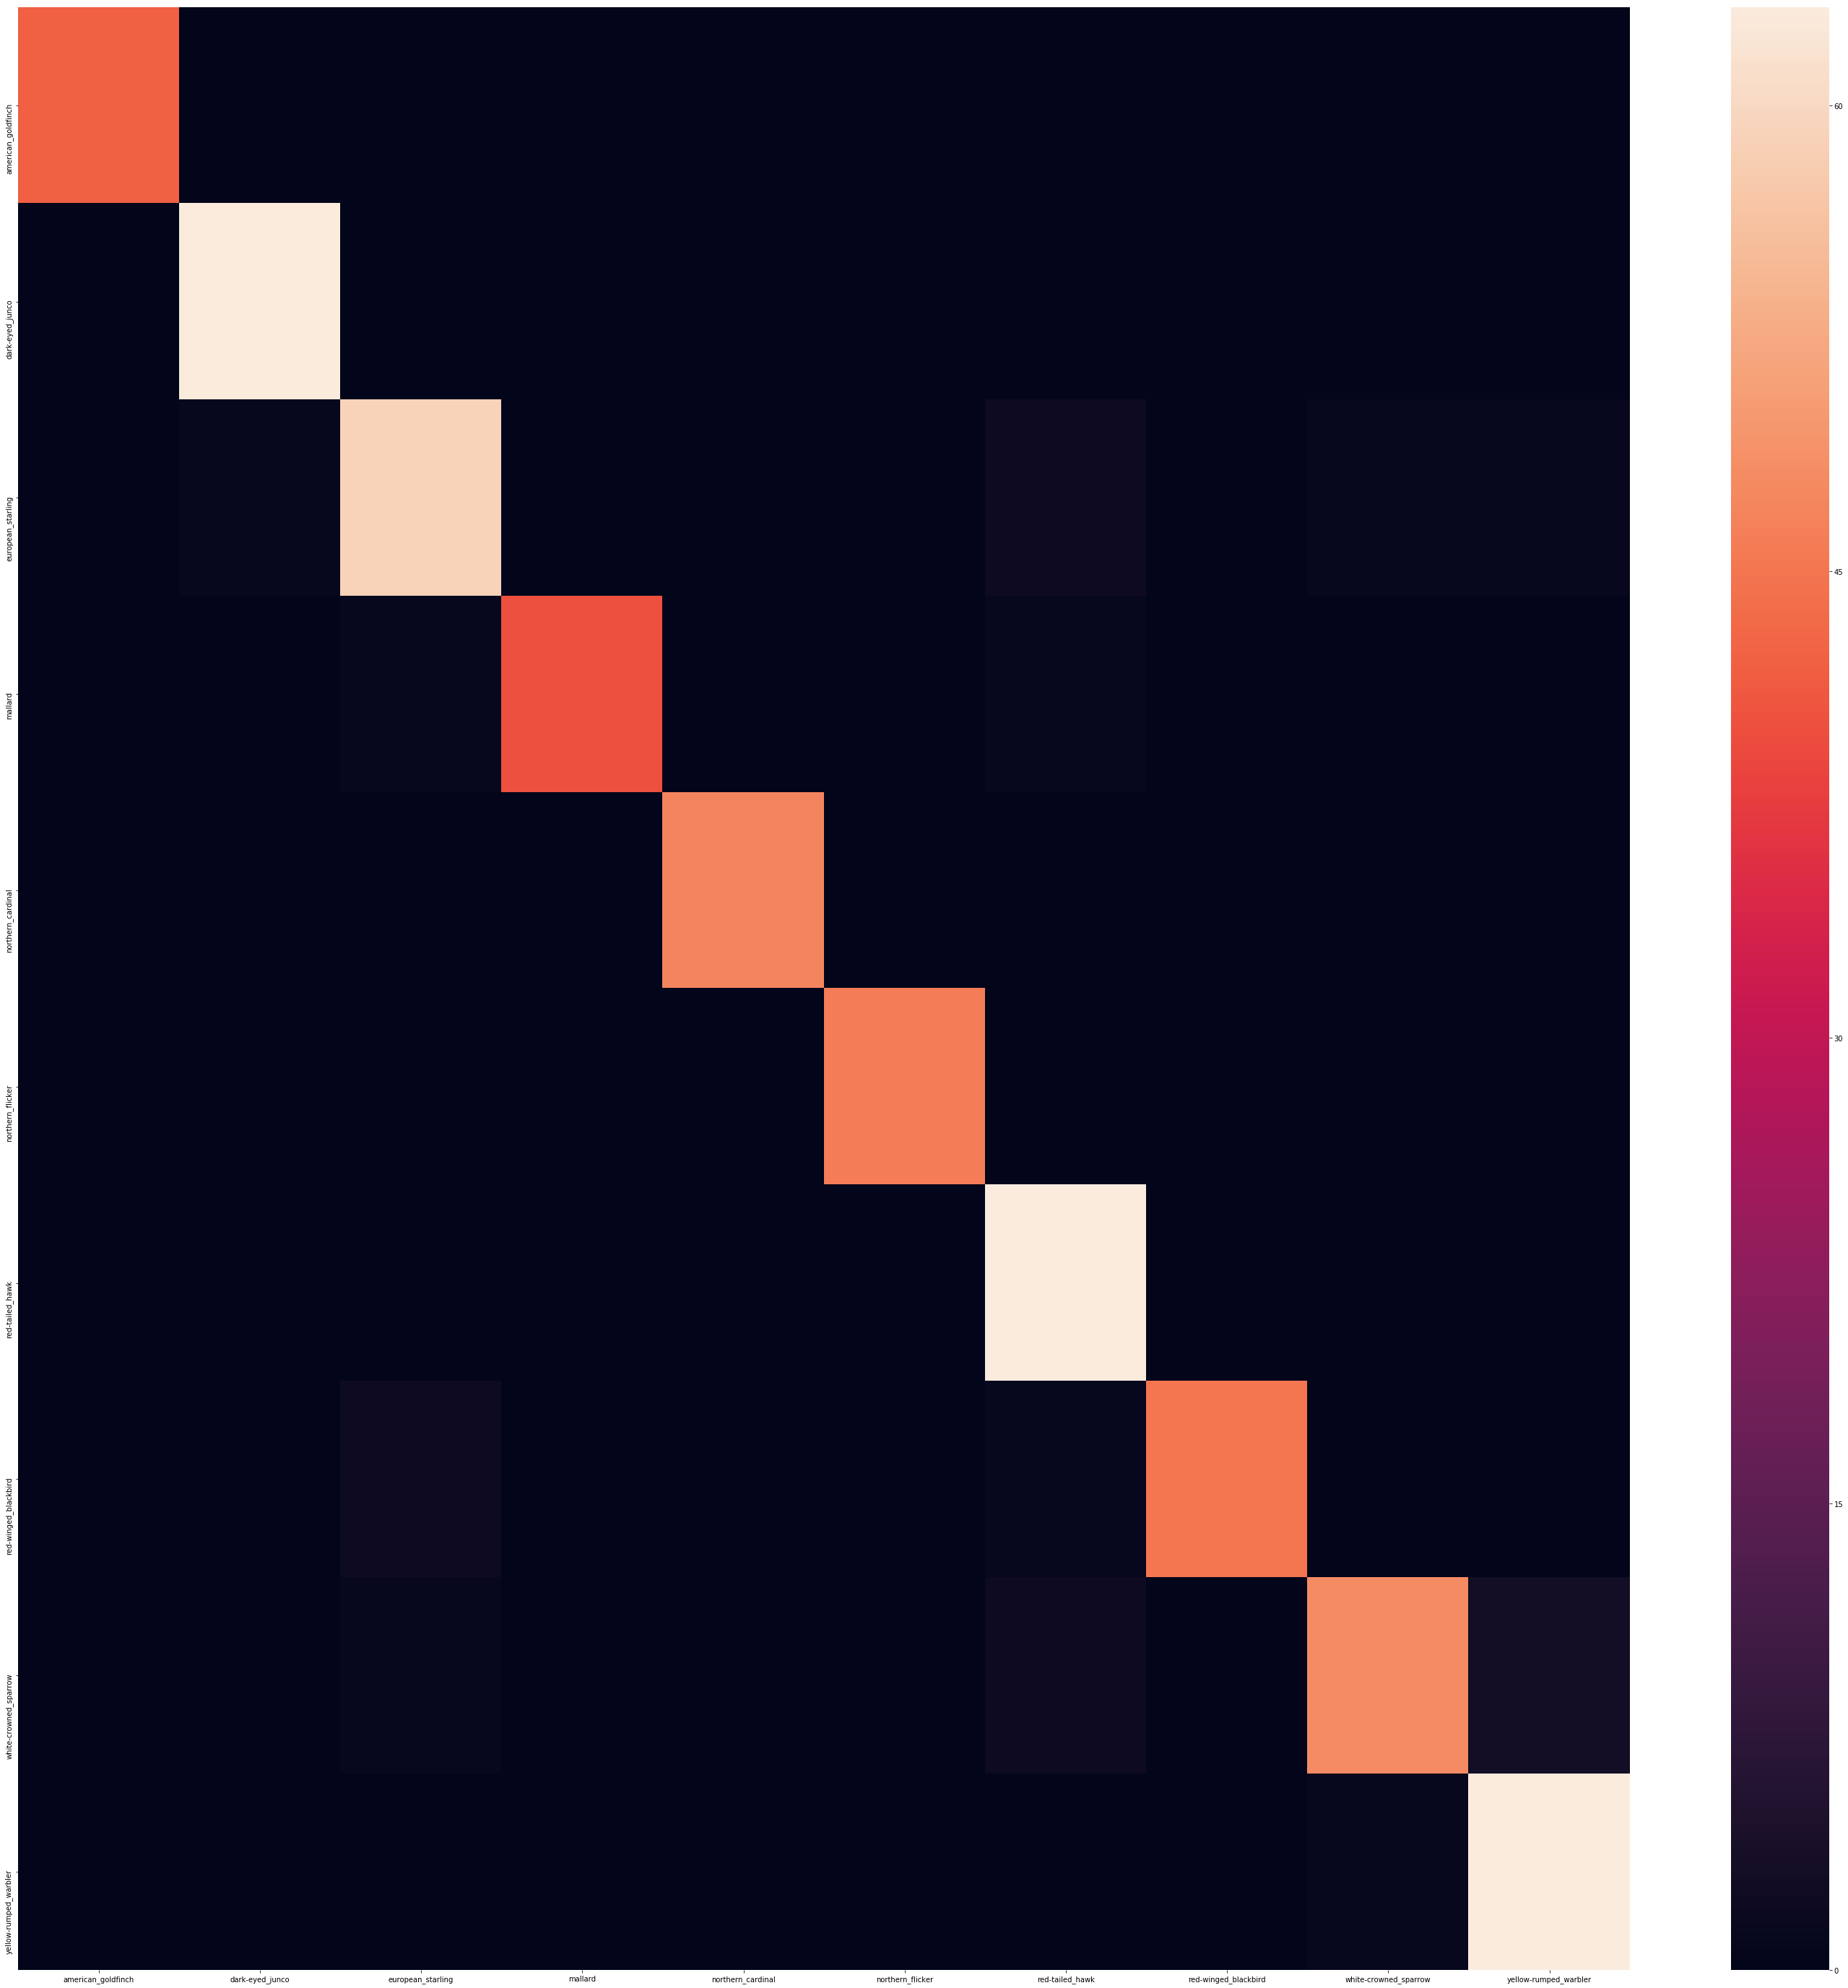

In [26]:
fig, ax = plt.subplots(figsize=(50, 50))
_ = sns.heatmap(cm, ax=ax, yticklabels=labels, xticklabels=labels, robust=True)

In [27]:
fastai.model.model_urls

{'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'}